# CSI 4142 Fundamentals of Data Science, Winter 2025
# Assignment 3 - Predictive Analysis - Regression and Classification

## Group A - 72
### Hilaire Junior Kalala - 300289737
### Johann Rajosefa - 300300054
 

## 1. Introduction

As part of Assignment 3 in the Fundamentals of Data Science course, we conducted a regression empirical study with linear regression. This project involved implementing and evaluating a linear regression approach for a predictive task. Additionally, we assessed the impact of removing outliers on the performance of the regression model. This study allowed us to apply several key concepts covered in class, particularly the crucial steps of data processing, including data cleaning, feature engineering, and outlier detection using the Local Outlier Factor (LOF) method.

To use the notebook, each cell can be executed to reproduce the steps taken in this study. However, they must be run in order; otherwise, errors may occur.

## 2. Dataset description : Medical Cost Personal Datasets

The chosen dataset, is designed to predict individual medical insurance charges billed by health insurance companies. It contains 1,338 entries, each representing a unique individual, with the following features:

    age: Age of the individual (integer)

    sex: Gender of the individual (male/female)

    bmi: Body Mass Index, a measure of body fat based on height and weight (float)

    children: Number of children/dependents covered by the insurance (integer)

    smoker: Smoking status of the individual (yes/no)

    region: Residential area in the U.S. (northeast, northwest, southeast, southwest)

    charges: Individual medical insurance charges billed by the insurance company (float)

This dataset is commonly used for regression analysis to understand how these variables influence medical insurance costs. It provides an excellent opportunity to apply linear regression techniques and assess the impact of factors like age, BMI, and smoking status on insurance charges.

In [58]:
# Initialization of libraries and dataset I am going to work with for the Data Clean Checker part
import os
import numpy as np
import pandas as pd

#Initialization of the dataset
med_dt = pd.read_csv("https://raw.githubusercontent.com/KugleBlitz007/CSI4142/f9b38d85aeae627aad6c6e2849e4b333363e9bc3/insurance.csv")
med_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## 3. Regression empirical study with Linear Regression

### a) Cleaning the data
In the previous assignment on Data Cleaning (Assignment 2), we implemented ten different functions to test the validity of a dataset. For this study, I will use data type check (for the age, charges and BMI columns), the Look-up Errors Check (for the sex, smoker and region columns) and and Exact Duplicate Check functions to verify the validity of the data for each variable. I chose only these 3 functions because they seemed the most relevant for the dataset I am working on. Additionally, the nature of the variables does not allow for other types of tests.

In [33]:
#First, we are gonna check that each row is unique and drop the duplicates if we find them
med_dt = med_dt.drop_duplicates(keep = False)
duplicates = med_dt[med_dt.duplicated(keep = 'first')]
duplicates


,age,sex,bmi,children,smoker,region,charges


In [39]:
#Second, I am going to check the data type for the values of the columns : age (int), charges (float) and BMI (float)

#1.Age
invalid_values1 = med_dt[~med_dt["age"].apply(lambda x: isinstance(x, int))]
#2.Charges
invalid_values2 = med_dt[~med_dt["charges"].apply(lambda x: isinstance(x, float))]
#3.BMI
invalid_values3 = med_dt[~med_dt["bmi"].apply(lambda x: isinstance(x, float))]

#If found, print rows with containing the invalid values
print(invalid_values1)
print(invalid_values2)
print(invalid_values3)

#As we can see the dataset passed the data type checks

Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [44]:
# Third, I am going to check that the values found in the columns of sex, smoker and region are in the tables of acceptable values for each of the 3 variables
def look_up( attr, acc_values):
    invalid_rows = med_dt[~med_dt[attr].isin(acc_values)]
    return invalid_rows
    
#1.Look-up errors check on Sex
attr = "sex"
acc_values = ["male","female"]
print("The rows containing an ivalid sex value are : ")
print(look_up(attr, acc_values))

#2.Look-up errors check on Sex
attr = "smoker"
acc_values = ["yes","no"]
print("The rows containing an ivalid smoker value are : ")
print(look_up(attr, acc_values))

#3.Look-up errors check on region
attr = "region"
acc_values = ["northeast", "northwest", "southeast", "southwest"]
print("The rows containing an ivalid region value are : ")
print(look_up(attr, acc_values))

#As we can see below, the dataset passed the Look-up errors check on all the 3 categrorical variables 

The rows containing an ivalid sex value are : 
The rows containing an ivalid smoker value are : 
The rows containing an ivalid region value are : 


,age,sex,bmi,children,smoker,region,charges


### b) Categorical feature encoding
Categorical feature encoding is essential for building regression models because most machine learning algorithms, including linear regression, work with numerical data. Since categorical variables contain text or labels, they need to be converted into a numerical format that the model can interpret. Without encoding, the model cannot process these categorical features, leading to errors or inaccurate predictions.

To address this, I will use the One-Hot Encoding approach to transform categorical variables. This method converts each category into a binary column (0 or 1), ensuring that the model correctly interprets categorical information without assuming an ordinal relationship between categories.

First, I am going to transform the sex feature into 2 new features: male and female. Then, I am going to transform the smoker feature into a numerical feature (1 for yes, 0 for no). 

In [53]:
#Creating the male and female new features
#I am going to create an array for each of the two features, then go through the elements of the sex column and append a 1 or a 0 to the male array and the female array

male = np.array([], dtype=int)
female = np.array([], dtype=int)

for s in med_dt.sex:
    if (s == "male"):
        male = np.append(male, 1)
        female = np.append(female, 0)
    else:
        male = np.append(male, 0)
        female = np.append(female, 1)

med_dt["male"] = male
med_dt["female"] = female

#checking that the new features have been created
med_dt.head(5)
        

,age,sex,bmi,children,smoker,region,charges,male,female
0,19,female,27.900,0,yes,southwest,16884.92400,0,1
1,18,male,33.770,1,no,southeast,1725.55230,1,0
2,28,male,33.000,3,no,southeast,4449.46200,1,0
3,33,male,22.705,0,no,northwest,21984.47061,1,0
4,32,male,28.880,0,no,northwest,3866.85520,1,0


In [54]:
#I am now going to transform the smoker feature into a numerical feature by using the same approach 
#In the new smoker feature yes are replaced by 1s and no by 0s
smoker = np.array([], dtype=int)
for y_n in med_dt.smoker:
    if (y_n == "yes"):
        smoker = np.append(smoker, 1)
    else:
        smoker = np.append(smoker, 0)

med_dt.smoker = smoker

#checking that the transformation has been done correctly
med_dt.head(5)


,age,sex,bmi,children,smoker,region,charges,male,female
0,19,female,27.900,0,1,southwest,16884.92400,0,1
1,18,male,33.770,1,0,southeast,1725.55230,1,0
2,28,male,33.000,3,0,southeast,4449.46200,1,0
3,33,male,22.705,0,0,northwest,21984.47061,1,0
4,32,male,28.880,0,0,northwest,3866.85520,1,0


### c) EDA and Outlier detection
For this section, I am first going to program a LOF (Local Outlier Factor) approach to detect outliers. Second, I am going to use boxplot to visualize the distributions of data on the different numerical features to find a feature that has at least one outlier. Third, I am going to find that outlier using my LOF approach and decide what to do with it (I am probably gonna remove it...).

The Local Outlier Factor (LOF) is an unsupervised anomaly detection algorithm that identifies outliers by comparing the density of a given point to its neighbors. The key idea is that an outlier will have a much lower density compared to surrounding points. LOF assigns an anomaly score to each data point based on how isolated it is from its neighbors. The density is calculated by measuring the reachability distance between a point and its neighbors.


In [44]:
#Implementation of the LOF approach using the LocalOutlierFactor class from scikit-learn
from sklearn.neighbors import LocalOutlierFactor
def apply_Lof(feat):

    # Selecting the feat (feature) column for outlier detection
    feat_values = med_dt[[feat]]  # Must be in 2D format for LOF

    # Applying the Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=50, contamination=0.008)  # 0.8% expected outliers
    outlier_labels = lof.fit_predict(feat_values)

    # LOF returns -1 for outliers, 1 for inliers
    med_dt['outlier_'+feat] = outlier_labels  # Adding results to dataset

    # Filtering out the outliers
    outliers = med_dt[med_dt['outlier_'+feat] == -1]

    #return the detected outliers
    print(outliers[[feat]])

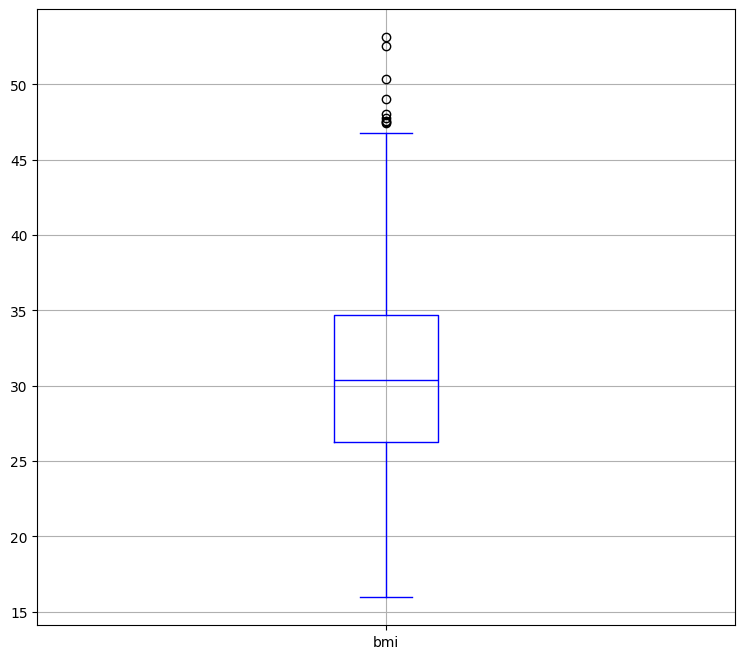

In [30]:
import matplotlib.pyplot as plt
#Now i am going to use boxplot to visualize the distributions of data on different features to find the feature having at least one outlier
med_dt.boxplot(column = "bmi",
               figsize = (9,8),
               color = "blue")
plt.show()

#As we can see in the boxplot, the dots above the blue line are outliers, so we're gonna use our LOF approach on the BMI feature to find those outliers 

In [51]:
#In this cell, we are using the apply_Lof function to find the outliers

apply_Lof("bmi")
#There are 11 outliers in my datasets using the parameters n_neighbors=50, contamination=0.008 for the LocalOutlierFactor class
#I am going to remove those outliers instead of considering them as missing values and imputing them using Linear regression

med_dt_no_outlier = med_dt[med_dt['outlier_bmi'] == 1]  # Keep only inliers

        bmi
116   49.06
172   15.96
286   48.07
401   47.52
438   46.75
543   47.41
847   50.38
860   47.60
1047  52.58
1088  47.74
1317  53.13


### d) Predictive analysis : Linear Regression (Explore the Linear regression method suggested in Scikit-learn)
The LinearRegression class from the sklearn.linear_model module is used to model the relationship between a dependent variable (target) and one or more independent variables (features). It assumes a linear relationship between the feature(s) and the target variable.

### e) feature engineering

### f) Empirical Study 


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = med_dt[['bmi']]  
y = med_dt['charges'] 

# a. Split your data into 3 subsets for train, validation and test sets. 


# First, split into Training (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Now split the Temp dataset into Validation (20%) and Test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset sizes
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 802 samples
Validation set: 268 samples
Test set: 268 samples


#### b. Decide on some evaluation metrics
I decided to use the MSE and the R2 score

In [56]:
# c. As baseline, use the linear regression with baseline settings, without outlier removal

# Initialize Linear Regression model
model = LinearRegression()
# Train (fit) the model
model.fit(X_train, y_train)

#The model has been trained, we're now going to predict the charges value using the model and evaluate it 
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")  # Higher R² means better fit

Mean Squared Error (MSE): 145665748.93
R² Score: 0.0609


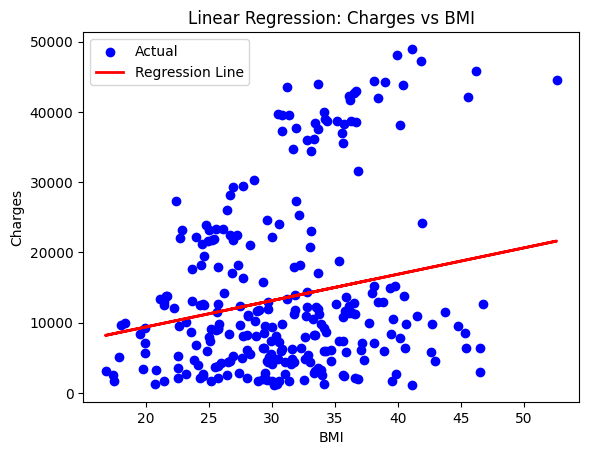

In [57]:
plt.scatter(X_test, y_test, color='blue', label="Actual")
plt.plot(X_test, y_pred, color='red', linewidth=2, label="Regression Line")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("Linear Regression: Charges vs BMI")
plt.legend()
plt.show()

In [59]:
#d. I am going to train a new model with the dataset without outlier 
X = med_dt_no_outlier[['bmi']]  
y =  med_dt_no_outlier['charges'] 

# a. Split your data into 3 subsets for train, validation and test sets. 


# First, split into Training (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Now split the Temp dataset into Validation (20%) and Test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset sizes
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 796 samples
Validation set: 265 samples
Test set: 266 samples


In [60]:
# Initialize Linear Regression model
model = LinearRegression()
# Train (fit) the model
model.fit(X_train, y_train)

#The model has been trained, we're now going to predict the charges value using the model and evaluate it 
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")  # Higher R² means better fit

Mean Squared Error (MSE): 138864244.29
R² Score: 0.0056


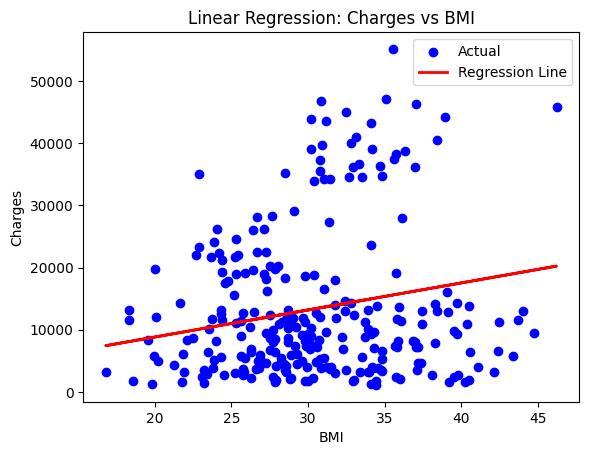

In [61]:
plt.scatter(X_test, y_test, color='blue', label="Actual")
plt.plot(X_test, y_pred, color='red', linewidth=2, label="Regression Line")
plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("Linear Regression: Charges vs BMI")
plt.legend()
plt.show()

### g) Result anlaysis and Conclusion
In this empirical study, we explored the impact of outlier removal using the Local Outlier Factor (LOF) method on a Linear Regression model. After comparing the models trained on both the original dataset and the dataset with outliers removed, we observed no significant difference in performance. The model’s predictive ability remained virtually unchanged, suggesting that the detected outliers did not strongly influence the regression results.

This outcome highlights the importance of carefully assessing the role of outliers in a dataset before deciding to remove them. While outlier removal is often expected to improve model accuracy, in this case, it did not yield any noticeable benefits. A more refined approach—such as using robust regression techniques, feature transformations, or alternative outlier detection methods—could potentially lead to better improvements in future studies.

Ultimately, this experiment underscores the need for a case-by-case evaluation of preprocessing techniques rather than assuming that outlier removal will always enhance model performance.

## 5. References
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html